In [1]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Google BigQuery SQL to get the blocks mined around a timestamp
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# SELECT * FROM `bigquery-public-data.crypto_ethereum.blocks`
# WHERE timestamp > "2020-12-20 23:59:50"
# and timestamp < "2020-12-21 00:00:10"
# order by timestamp

In [2]:
REALTIME_ESTIMATOR = False
# set the window of blocks, will be overwritten if REALTIME_ESTIMATOR == True
WEEK = 29
START_BLOCK = 11447731
END_BLOCK = 11493367

In [3]:
from google.cloud import bigquery


if REALTIME_ESTIMATOR:
    import warnings
    warnings.warn('Running realtime estimator')
    
    from urllib.request import urlopen
    import json
    url = 'https://ipfs.fleek.co/ipns/balancer-team-bucket.storage.fleek.co/balancer-claim/snapshot'
    jsonurl = urlopen(url)
    claims = json.loads(jsonurl.read())
    past_weeks = [20+int(w) for w in claims.keys()]
    most_recent_week = max(past_weeks)
    WEEK = most_recent_week + 1 # we'll be computing estimates for this week
    print(f'Earnings for week {most_recent_week} found on IPFS. Computing estimates for week {WEEK}')
    
    from datetime import datetime
    week_1_start = '01/06/2020 00:00:00 UTC'
    week_1_start = datetime.strptime(week_1_start, '%d/%m/%Y %H:%M:%S %Z')
    TRUE_WEEK = int(1 + (datetime.utcnow() - week_1_start).days/7)  # this is what week we're actually in
    
    # if TRUE_WEEK == WEEK then START_BLOCK is the first block of the TRUE_WEEK
    # else then we need to start the week before
    delta_weeks = TRUE_WEEK - WEEK
    
    sql = '''
    SELECT number FROM `bigquery-public-data.crypto_ethereum.blocks`
    where timestamp >= TIMESTAMP_SUB(TIMESTAMP_TRUNC(CURRENT_TIMESTAMP(), WEEK(MONDAY)), interval {} DAY)
    and timestamp <= TIMESTAMP_ADD(TIMESTAMP_TRUNC(CURRENT_TIMESTAMP(), WEEK(MONDAY)), interval 1 HOUR)
    order by timestamp
    limit 1
    '''.format(delta_weeks*7)
    results = bigquery.Client().query(sql).result()
    for row in results:
        START_BLOCK = row.number

    sql = '''
    SELECT MAX(number) as number FROM `bigquery-public-data.crypto_ethereum.blocks`
    '''
    results = bigquery.Client().query(sql).result()
    for row in results:
        END_BLOCK = row.number

In [4]:
import time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2020-12-21 13:49:54


In [5]:
from web3 import Web3
import os
web3_provider = os.environ['ENDPOINT_URL']
w3 = Web3(Web3.WebsocketProvider(web3_provider))
start_block_timestamp = w3.eth.getBlock(START_BLOCK).timestamp
end_block_timestamp = w3.eth.getBlock(END_BLOCK).timestamp

Consider installing rusty-rlp to improve pyrlp performance with a rust based backend


In [6]:
import pandas as pd
# get list of tokens eligible for liquidity mining
ELIGIBLE_TOKENS_URL = {
    24: 'https://raw.githubusercontent.com/balancer-labs/assets/6b1e9875e2fb81965be0251c359c1fc390af0e43/lists/eligible.json',
    25: 'https://raw.githubusercontent.com/balancer-labs/assets/026076f7ef6094107a54468593ec91b9f94accc1/lists/eligible.json',
    26: 'https://raw.githubusercontent.com/balancer-labs/assets/5c00bfadc1a128be6562bc7a758c0bc323b4a7b9/lists/eligible.json',
    27: 'https://raw.githubusercontent.com/balancer-labs/assets/f822ccf/lists/eligible.json',
    28: 'https://raw.githubusercontent.com/balancer-labs/assets/1d43a75/lists/eligible.json',    
    29: 'https://raw.githubusercontent.com/balancer-labs/assets/a35d955/lists/eligible.json',    
}
if REALTIME_ESTIMATOR:
    whitelist_df = pd.read_json('https://raw.githubusercontent.com/balancer-labs/assets/master/lists/eligible.json')
else:
    whitelist_df = pd.read_json(ELIGIBLE_TOKENS_URL[WEEK])

In [7]:
from urllib.request import urlopen
import json5 as json
if REALTIME_ESTIMATOR:
    url = 'https://raw.githubusercontent.com/balancer-labs/bal-mining-scripts/master/config/blacklisted_sharelholders.json'
    jsonurl = urlopen(url)
    BLACKLISTED_SHAREHOLDERS = json.loads(jsonurl.read())['address']

    url = 'https://raw.githubusercontent.com/balancer-labs/bal-mining-scripts/master/config/equivalent_sets.json5'
    jsonurl = urlopen(url)
    EQUIVALENT_SETS = json.loads(jsonurl.read())['sets']
else:
    BLACKLISTED_SHAREHOLDERS = json.load(open('config/blacklisted_sharelholders.json'))['address']
    EQUIVALENT_SETS = json.load(open('config/equivalent_sets.json5'))['sets']
    
BLACKLISTED_SHAREHOLDERS_lower = [x.lower() for x in BLACKLISTED_SHAREHOLDERS]

In [8]:
BAL_TOKEN = '0xba100000625a3754423978a60c9317c58a424e3D'
SNAPSHOT_WINDOW_SIZE = 256
CLAIM_PRECISION = 18 # leave out of results addresses that mined less than 1E-18 BAL
WEEKLY_MINED = 145000
LIQUIDITY_STAKING = 45000
if REALTIME_ESTIMATOR:
    week_passed = (end_block_timestamp - start_block_timestamp)/(7*24*3600)
    WEEKLY_MINED = int(WEEKLY_MINED*week_passed)
    LIQUIDITY_STAKING = int(LIQUIDITY_STAKING*week_passed)
STAKERS_SHARE = LIQUIDITY_STAKING / WEEKLY_MINED
reports_dir = f'reports/{WEEK}'

In [9]:
import os
if not os.path.exists(reports_dir):
    os.mkdir(reports_dir)

In [10]:
import numpy as np

flatten_list = lambda t: [item for sublist in t for item in sublist]

def get_wrap_factor_of_pair(a, b):
    a = Web3.toChecksumAddress(a)
    b = Web3.toChecksumAddress(b)
    for soft in EQUIVALENT_SETS:
        for hard in soft:
            if a in hard and b in hard:
                return .1
        flat = flatten_list(soft)
        if a in flat and b in flat:
            return .2
    return 1


def get_wrap_factor(tokens_weights):
    length = len(tokens_weights)
    shape = (length, length)
    wf_matrix = np.zeros(shape)
    tokens = tokens_weights.index.get_level_values('token_address')
    for i in range(len(tokens_weights)-1):
        for j in range(i+1, len(tokens_weights)):
            wf_matrix[i,j] = wf_matrix[i,j] + get_wrap_factor_of_pair(tokens[i],tokens[j])
    weights_vector = np.array(tokens_weights)
    weights_matrix = np.outer(weights_vector,weights_vector.T)
    try:
        element_wise_product = weights_matrix * wf_matrix
    except:
        print(tokens_weights)
        print(weights_matrix)
        print(wf_matrix)
        raise
    return element_wise_product.sum()/np.triu(weights_matrix, k=1).sum()

In [11]:
def get_staking_boosts_of_pair(a, b, bal_multiplier=1):
    a = Web3.toChecksumAddress(a)
    b = Web3.toChecksumAddress(b)
    if a==BAL_TOKEN:
        cap_b = whitelist_df.loc[b.lower(),'cap']
        if cap_b == np.inf:
            return (bal_multiplier, 1)
        else:
            return (1, 1)
    elif b==BAL_TOKEN:
        cap_a = whitelist_df.loc[a.lower(),'cap']
        if cap_a == np.inf:
            return (1, bal_multiplier)
        else:
            return (1, 1)
    else:
        return (1, 1)


def get_BRF(tokens_weights, bal_multiplier=1):
    if type(bal_multiplier) != int: # expect a series of BAL multipliers on the third pass
        block_number = tokens_weights.index.get_level_values('block_number').drop_duplicates().values
        if len(block_number)>1:
            raise Exception('got more than one block_number {}'.format(block_number))
        else:
            bal_multiplier = final_bal_multiplier[block_number[0]]
            
    if 'shareholders_subpool' in tokens_weights.index.names:
        if tokens_weights.index.get_level_values('shareholders_subpool').all():
            bal_multiplier=1
    else:
        if tokens_weights.index.nlevels==4:
            raise Exception('shareholders_subpool not in index')    
            
    denominator = 0
    numerator = 0
    token_address = list(tokens_weights.index.get_level_values('token_address'))
    token_weights = list(tokens_weights)
    for i in range(len(tokens_weights)-1):
        for j in range(i+1, len(tokens_weights)):
            token_A = token_address[i]
            token_B = token_address[j]
            weight_A = token_weights[i]
            weight_B = token_weights[j]
            staking_boosts = get_staking_boosts_of_pair(token_A, token_B, bal_multiplier)
            staking_boost_A = staking_boosts[0]
            staking_boost_B = staking_boosts[1]
            staking_boost_of_pair = (staking_boost_A * weight_A + staking_boost_B * weight_B) / (weight_A + weight_B)
            
            ratio_factor = 4 * (weight_A / (weight_A + weight_B)) * (weight_B / (weight_A + weight_B))
            
            numerator += staking_boost_of_pair * ratio_factor * weight_A * weight_B
            denominator += weight_A * weight_B
    return numerator/denominator

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

In [13]:
from tqdm.auto import tqdm
def get_list_of_snapshot_blocks(start, end):
    block_list = range(end, start, -SNAPSHOT_WINDOW_SIZE)
    block_list = list(block_list)
    block_list.sort()
    return block_list

snapshot_blocks = get_list_of_snapshot_blocks(START_BLOCK, END_BLOCK)
snapshot_timestamps_blocks = {w3.eth.getBlock(b).timestamp: b \
                              for b in tqdm(snapshot_blocks, 'Getting snapshot timestamps')}
snapshot_blocks_timestamps = {v: k for k,v in snapshot_timestamps_blocks.items()}
snapshot_blocks_as_str = [str(b) for b in snapshot_blocks]
print('week {}: {} snapshot blocks'.format(WEEK, len(snapshot_blocks)))
print('week {}: first snapshot block: {} ({}...)'.format(WEEK, min(snapshot_blocks), snapshot_blocks[:3]))
print('week {}: last snapshot block: {} (...{})'.format(WEEK, max(snapshot_blocks), snapshot_blocks[-3:]))


week 29: 179 snapshot blocks
week 29: first snapshot block: 11447799 ([11447799, 11448055, 11448311]...)
week 29: last snapshot block: 11493367 (...[11492855, 11493111, 11493367])


In [14]:
# remove kovan
whitelist_df.drop(columns=['kovan'], inplace=True)
whitelist_df.dropna(inplace=True)
# convert string to cap
whitelist_df.rename(columns={'homestead':'cap'}, inplace=True)
CAP_TIERS = {
    'cap1':   1e6,
    'cap2':   3e6,
    'cap3':  10e6,
    'cap4':  30e6,
    'cap5': 100e6,
    'uncapped': np.inf,
}
whitelist_df['cap'] = whitelist_df['cap'].apply(lambda x: CAP_TIERS[x])
# lower case the token addresses for later join
whitelist_df.index.name = 'checksum_token_address'
whitelist_df.reset_index(inplace=True)
whitelist_df['checksum_token_address'] = whitelist_df['checksum_token_address'].apply(Web3.toChecksumAddress)
whitelist_df.set_index(whitelist_df['checksum_token_address'].str.lower(), inplace=True)
whitelist_df.index.name = 'token_address'

In [15]:
# get decimals of whitelisted tokens
import json
from web3.exceptions import ABIFunctionNotFound, BadFunctionCallOutput, InvalidAddress
token_abi = json.load(open('abi/BToken.json'))
def get_token_decimals(token_address):
    try:
        token_contract = w3.eth.contract(token_address, abi=token_abi)
    except InvalidAddress:
        print('Invalid Address: ' + token_address)
        raise
    try:
        return token_contract.functions.decimals().call()
    except ABIFunctionNotFound:
        print(f'{token_address} does not implement decimals(), assuming 0')
        return 0
    except BadFunctionCallOutput:
        print(f'{token_address}: decimals() returned bad output, assuming 0')
        return 0
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Getting token decimals from ethereum node...')
whitelist_df['decimals'] = whitelist_df['checksum_token_address'].apply(get_token_decimals)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done!')

2020-12-21 13:50:32 - Getting token decimals from ethereum node...
0xE0B7927c4aF23765Cb51314A0E0521A9645F0E2A: decimals() returned bad output, assuming 0
2020-12-21 13:51:48 - Done!


In [16]:
# get USD prices of whitelist tokens
import requests
from time import sleep
from tqdm.auto import tqdm
import json


if REALTIME_ESTIMATOR:
    prices_json = {}
else:
    try:
        prices_json = json.load(open(reports_dir+'/_prices.json'))
    except FileNotFoundError:
        prices_json = {}

MARKET_API_URL = 'https://api.coingecko.com/api/v3'
price_query = MARKET_API_URL+'/coins/ethereum/contract/{}/market_chart/range?&vs_currency=usd&from={}&to={}'
time_bounded_price_query = price_query.format('{}', start_block_timestamp, end_block_timestamp)
whitelist_df['prices_api_response'] = ''
whitelist_df['prices_dict'] = ''
for i in tqdm(whitelist_df.index, 'Getting prices'):
    checksum_token_address = whitelist_df.loc[i,'checksum_token_address']
    query_url = time_bounded_price_query.format(checksum_token_address)
    # when running week 26 we ran across a bug in Coingecko price feed where the price of WETH was reported as 0
    # price of ETH is unaffected, so using it instead
    if '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2' in query_url:
        query_url = query_url.replace('/contract/0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2','')
    prices_dict = {'prices': prices_json.get(checksum_token_address, None)}
    if prices_dict['prices'] is None:
        prices_dict = None
    tries = 0
    while prices_dict is None:
        token_prices = requests.get(query_url)
        try:
            prices_dict = json.loads(token_prices.content)
        except:
            pass
        # sleep for one second to avoid being blocked
        sleep(1)
        tries += 1
        if tries > 5:
            break
        whitelist_df.loc[i,'prices_api_response'] = token_prices.content
    whitelist_df.loc[i,'prices_dict'] = [prices_dict]

In [17]:
import json

tokens_not_found = whitelist_df[whitelist_df['prices_dict'].apply(lambda x: 'error' in x.keys())].index
whitelist_df.drop(index=tokens_not_found, inplace=True)
print('Tokens not found in Coingecko: {}'.format(list(tokens_not_found)))

whitelist_df['prices_lists'] = whitelist_df['prices_dict'].apply(lambda x: x.get('prices'))
prices_not_found = whitelist_df[whitelist_df['prices_lists'].apply(lambda x: len(x)==0)].index
whitelist_df.drop(index=prices_not_found, inplace=True)
print('Prices not found in Coingecko for: {}'.format(list(prices_not_found)))

exploded_whitelist_df = whitelist_df.explode('prices_lists').dropna()
exploded_whitelist_df.reset_index(inplace=True)
exploded_whitelist_df[['timestamp','price']] = pd.DataFrame(exploded_whitelist_df.prices_lists.tolist(), index=exploded_whitelist_df.index)

prices_df = exploded_whitelist_df[['token_address', 'checksum_token_address', 'cap', 'timestamp', 'price']].copy()

prices_df['ts_price'] = prices_df.apply(lambda x: [x['timestamp'], x['price']], axis=1)

if not REALTIME_ESTIMATOR:
    prices_df.groupby('checksum_token_address').agg(list)['ts_price'].to_json(reports_dir+'/_prices.json',
                                                                 orient='index',
                                                                 indent=4
                                                                )

prices_df['timestamp'] = prices_df['timestamp']//1000

Tokens not found in Coingecko: ['0x4c327471c44b2dacd6e90525f9d629bd2e4f662c', '0xe5f166c0d8872b68790061317bb6cca04582c912', '0xa645264c5603e96c3b0b078cdab68733794b0a71', '0x70a72833d6bf7f508c8224ce59ea1ef3d0ea3a38', '0xbd6467a31899590474ce1e84f70594c53d628e46']
Prices not found in Coingecko for: ['0x7d2d3688df45ce7c552e19c27e007673da9204b8', '0x71010a9d003445ac60c4e6a7017c1e89a477b438', '0x261b45d85ccfeabb11f022eba346ee8d1cd488c0', '0xc7d79021cd127a2f35b1e26fe3c4aad67f5c28b8', '0x54355ae0485f9420e6ce4c00c10172dc8e5728a3', '0x07509c281b55a1675d3f71f1c4ab67829eb731d3', '0x0bf54992649c19bd8db4080078a32383827352f3', '0x48ac44f4e29e602f851b84c271c22b85b9447251', '0xc7088fac73c55bfae5c2a963c3029b072c7dff25', '0x8abf3a95862619a55fa00cb3e4eedbe113ff468c', '0x2409d6059e2a8130c099e49f3cb418fd6c3d9aff', '0xd218d75ba0fc45858a4e9ef57a257ed9977db5f4', '0xbddd682e63dd9f9fa3b97aea88772e77cf3e5013', '0x78481fb80caabb252909218164266ac83f815000', '0x1003ec54f51565ff86ac611184ea23d6310cae71', '0xabc754ac2

In [18]:
# get eligible token balances of every balancer pool at every snapshot block from Big Query
get_pools_sql = '''
SELECT pool FROM `blockchain-etl.ethereum_balancer.BFactory_event_LOG_NEW_POOL` 
'''

sql = """
select * from `blockchain-etl.ethereum_balancer.view_token_balances_subset`
where token_address in (\'{0}\')
and address in ({1})
and token_address not in ('0xd46ba6d942050d489dbd938a2c909a5d5039a161')
and block_number in ({2})
and balance > 0

union all

select '0xd46ba6d942050d489dbd938a2c909a5d5039a161' as token_address,
* from `blockchain-etl.ethereum_balancer.view_token_balances_subset_AMPL`
where address in ({1})
and block_number in ({2})
and balance > 0

""".format('\',\''.join(whitelist_df.index), # only get balances of tokens for which there is a price feed
           get_pools_sql, 
           ','.join(snapshot_blocks_as_str))
# print(sql)

In [19]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Querying BigQuery...')

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
pools_balances = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
n = len(pools_balances)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + f' - Done ({n} records)')

2020-12-21 14:02:42 - Querying BigQuery...
2020-12-21 14:03:53 - Done (677454 records)


In [20]:
pools_balances['scaled_balance'] = pools_balances['balance'] * pools_balances.join(whitelist_df['decimals'], on='token_address')['decimals'].apply(lambda x: 10**(-x))
pools_balances['timestamp'] = pools_balances['block_number'].apply(lambda x: snapshot_blocks_timestamps[x])

In [21]:
pools_balances.set_index(['address','block_number','token_address'], inplace=True)
number_of_liquid_eligible_tokens = pools_balances.groupby(['address','block_number']).size()
number_of_liquid_eligible_tokens.name = 'number_of_liquid_eligible_tokens'
pools_balances = pools_balances.join(number_of_liquid_eligible_tokens)
eligible_pools_balances = pools_balances[pools_balances['number_of_liquid_eligible_tokens']>=2].copy()
eligible_pools_balances.reset_index(inplace=True)

In [22]:
# merge balances and prices datasets on nearest timestamp, and compute USD balance of each token in each pool at each block
usd_pools_balances = pd.merge_asof(eligible_pools_balances.sort_values(by='timestamp'), 
                                   prices_df.sort_values(by='timestamp'), 
                                   on='timestamp', by='token_address', direction='nearest')
usd_pools_balances['usd_balance'] = usd_pools_balances['scaled_balance'] * usd_pools_balances['price']

In [23]:
# get token weights and swap fees of pools with public swap enabled
sql = """
select W.*, COALESCE(swapFee,'1000000000000') as swapfee
from `blockchain-etl.ethereum_balancer.view_pools_tokens_denorm_weights` W
left join `blockchain-etl.ethereum_balancer.view_pools_fees` F
on W.address = F.address and W.block_number = F.block_number
left join `blockchain-etl.ethereum_balancer.view_pools_public_swaps` S
on W.address = S.address and W.block_number = S.block_number
where COALESCE(public_,'false') = 'true'
and W.denorm > 0
and token_address in (\'{}\')
and W.address in ('{}')
and W.block_number in ({})
""".format('\',\''.join(whitelist_df.index), # only get weights of tokens for which there is a price feed
           '\',\''.join(eligible_pools_balances['address'].drop_duplicates()), 
           ','.join(snapshot_blocks_as_str))
# print(sql)

In [24]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Querying BigQuery...')

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
pools_weights = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
n = len(pools_weights)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + f' - Done ({n} records)')

2020-12-21 14:04:04 - Querying BigQuery...
2020-12-21 14:07:06 - Done (568720 records)


In [25]:
# the merge removes records associated with balances of tokens that are not part of the pool
pools_weights_balances = pools_weights.merge(usd_pools_balances, 
                                             on=['address', 'token_address', 'block_number'],
                                             how='inner')
pools_weights_balances.set_index(['address', 'token_address', 'block_number'], inplace=True)
pools_weights_balances['denorm'] = pools_weights_balances['denorm'].apply(float)
summed_weights = pools_weights_balances['denorm'].groupby(['address','block_number']).sum()
norm_weights = pools_weights_balances['denorm'] / summed_weights
norm_weights.name = 'norm_weights'
pools_weights_balances = pools_weights_balances.join(norm_weights)
# remove pools with only one eligible token
pools_weights_balances = pools_weights_balances[pools_weights_balances['norm_weights']<1]

In [26]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Computing wrap factor...')
wrap_factor = pools_weights_balances['norm_weights'].\
                    groupby(['address','block_number']).\
                    agg(get_wrap_factor)
wrap_factor.name = 'wrap_factor'
pools_weights_balances = pools_weights_balances.join(wrap_factor)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done')

2020-12-21 14:07:16 - Computing wrap factor...
2020-12-21 14:16:38 - Done


In [27]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Computing BRF (first pass)...')
brf = pools_weights_balances['norm_weights']. \
                groupby(['address','block_number']). \
                agg(get_BRF)
brf.name = 'first_pass_brf'
pools_weights_balances = pools_weights_balances.join(brf)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done')

2020-12-21 14:16:38 - Computing BRF (first pass)...
2020-12-21 14:23:21 - Done


In [28]:
# compute the fee factor
# https://forum.balancer.finance/t/modifying-feefactor-toward-reducing-the-mining-penalty-for-high-fee-pools/103
# a swapfee of 1% is stored in the smart contracts as 1e+16 (0.01e+18)
# fee factor formula as defined in the specs above takes as argument the fee as a percentage (eg 1 for a fee of 1% - not 0.01)
pools_weights_balances['fee_factor'] = np.exp(-(0.25 * \
                                                (100 * \
                                                 (pools_weights_balances['swapfee'].astype(float) / 1E18)))**2)

In [29]:
pools_weights_balances['adjustedLiquidityPreTokenCap'] = pools_weights_balances['usd_balance'] * \
                                                            pools_weights_balances['fee_factor'] * \
                                                            pools_weights_balances['wrap_factor'] * \
                                                            pools_weights_balances['first_pass_brf']

In [30]:
# compute the tokenCapFactor for each token_address at each block_number
tokenCapFactor = np.minimum(1, whitelist_df['cap'] / (pools_weights_balances['adjustedLiquidityPreTokenCap'].\
    groupby(['block_number','token_address']).\
    sum().\
    sort_values()))
tokenCapFactor.name = 'tokenCapFactor'
pools_weights_balances = pools_weights_balances.join(tokenCapFactor)

In [31]:
pools_weights_balances['token_capped_usd_balance'] = pools_weights_balances['usd_balance'] * \
                                                        pools_weights_balances['tokenCapFactor']

In [32]:
# get liquidity providers and the amount of BPT each has
# private and smart pools don't have BPT, so we assign 1 fictitious BPT to the controller
# BAL mined by controllers of smart pools created by the CRPFactory will be redistributed to the controller token holders later in the process
sql = """
with shared_pools as (
  select token_address as address, address as bpt_holder, block_number, balance as bpt from `blockchain-etl.ethereum_balancer.view_token_balances_subset`
  where token_address in ('{0}')
  and block_number in ({1})
  and balance > 0
),
private_pools as (
  select address, controller as bpt_holder, block_number, 1 as bpt from `blockchain-etl.ethereum_balancer.view_pools_controllers`
  where address not in (select address from shared_pools)
  and block_number in ({1})
)
select * from shared_pools
union all
select * from private_pools
""".format('\',\''.join(pools_weights_balances.index.get_level_values('address').drop_duplicates()), 
           ','.join(snapshot_blocks_as_str))
# print(sql)

In [33]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Querying BigQuery...')

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
bpt_balances = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
n = len(bpt_balances)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + f' - Done ({n} records)')

2020-12-21 14:23:24 - Querying BigQuery...
2020-12-21 14:27:05 - Done (2576502 records)


In [34]:
is_shareholder = bpt_balances['bpt_holder'].isin(BLACKLISTED_SHAREHOLDERS_lower)
bpt_balances['is_shareholder'] = is_shareholder
bpt_balances.set_index(['address','block_number','is_shareholder','bpt_holder'], inplace=True)
bpt_balances.rename_axis(index={'is_shareholder': 'shareholders_subpool'}, inplace=True)

In [35]:
# split pools that have a blacklisted shareholder as one of their LPs
split_pools = bpt_balances['bpt'].groupby(['address','block_number','shareholders_subpool']).sum()
total_bpt = bpt_balances['bpt'].groupby(['address','block_number']).sum()
relative_size_of_subpool = split_pools/total_bpt
relative_size_of_subpool.name = 'relative_size_of_subpool'
subpools = pools_weights_balances.join(relative_size_of_subpool, how='inner')

# recompute values according to the relative size of the subpool
splitable_cols = ['balance', 'scaled_balance', 'usd_balance', 'adjustedLiquidityPreTokenCap', 
                'token_capped_usd_balance']
for c in splitable_cols:
    subpools[c] = subpools[c] * subpools['relative_size_of_subpool']

In [36]:
TEMP_BAL_MULTIPLIER = 3
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Second BRF - no BAL multiplier...')

brf = subpools['norm_weights']. \
                groupby(['address','block_number','shareholders_subpool']). \
                agg(get_BRF)
brf.name = 'second_pass_brf_mult1'
subpools = subpools.join(brf)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done')

print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + f' - Second BRF - with temp BAL multiplier ({TEMP_BAL_MULTIPLIER})...')
brf = subpools['norm_weights']. \
                groupby(['address','block_number','shareholders_subpool']). \
                agg(get_BRF, bal_multiplier = TEMP_BAL_MULTIPLIER)
brf.name = 'second_pass_brf_with_temp_mult'
subpools = subpools.join(brf)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done')

2020-12-21 14:27:22 - Second BRF - no BAL multiplier...
2020-12-21 14:34:46 - Done
2020-12-21 14:34:46 - Second BRF - with temp BAL multiplier (3)...
2020-12-21 14:42:31 - Done


In [37]:
subpools['adjustedLiquidityPreStaking'] = subpools['token_capped_usd_balance'] * \
                                            subpools['fee_factor'] * \
                                            subpools['wrap_factor'] * \
                                            subpools['second_pass_brf_mult1']

subpools['adjustedLiquidityWithTempStakingMult'] = subpools['token_capped_usd_balance'] * \
                                            subpools['fee_factor'] * \
                                            subpools['wrap_factor'] * \
                                            subpools['second_pass_brf_with_temp_mult']

In [38]:
# compute final BAL multiplier
total_adjustedLiquidityPreStaking = subpools['adjustedLiquidityPreStaking'].groupby('block_number').sum()
total_adjustedLiquidityWithStakingTempMult = subpools['adjustedLiquidityWithTempStakingMult'].groupby('block_number').sum()
final_desired_adjusted_liquidity = total_adjustedLiquidityPreStaking / (1-STAKERS_SHARE)
stretch = (final_desired_adjusted_liquidity - total_adjustedLiquidityPreStaking) / \
            (total_adjustedLiquidityWithStakingTempMult - total_adjustedLiquidityPreStaking)
final_bal_multiplier = 1 + stretch * (TEMP_BAL_MULTIPLIER - 1)

In [39]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Third BRF - with final BAL multiplier...')
brf = subpools['norm_weights']. \
                groupby(['address','block_number','shareholders_subpool']). \
                agg(get_BRF, bal_multiplier = final_bal_multiplier)
brf.name = 'third_pass_brf_with_final_mult'
subpools = subpools.join(brf)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done')

2020-12-21 14:42:31 - Third BRF - with final BAL multiplier...
2020-12-21 14:52:04 - Done


In [40]:
# compute the final adjusted liquidity of each token in each subpool at each block
subpools['finalAdjustedLiquidity'] = subpools['token_capped_usd_balance'] * \
                                            subpools['fee_factor'] * \
                                            subpools['wrap_factor'] * \
                                            subpools['third_pass_brf_with_final_mult']

In [41]:
# compute the total final adjusted liquidity at each block
total_final_adjustedLiquidity = subpools['finalAdjustedLiquidity'].groupby('block_number').sum()

# compute the share of liquidity provided by each token in each subpool
share_of_liquidity = subpools['finalAdjustedLiquidity'] / total_final_adjustedLiquidity
share_of_liquidity.name = 'share_of_liquidity'
subpools = subpools.join(share_of_liquidity)

# compute the BAL mined by each token in each subpool at each block, proportional to the share of liquidity
subpools['BAL_mined'] = subpools['share_of_liquidity'] * WEEKLY_MINED / len(snapshot_blocks)

In [42]:
# compute the BAL mined by each LP proportional to their share of the pool
bal_mined_by_subpool_per_block = subpools['BAL_mined']. \
                                    groupby(['address','block_number','shareholders_subpool']). \
                                    sum()

total_bpt = bpt_balances['bpt'].groupby(['address','block_number','shareholders_subpool']).sum()
share_of_pool = bpt_balances['bpt'] / total_bpt

bal_mined = bpt_balances.copy()
bal_mined['bal_mined'] = (bal_mined_by_subpool_per_block * share_of_pool)
bal_mined.reset_index(inplace=True)
chksums = {x: Web3.toChecksumAddress(x) for x in bal_mined['bpt_holder'].drop_duplicates()}
bal_mined['chksum_bpt_holder'] = bal_mined['bpt_holder'].apply(lambda x: chksums[x])
bal_mined.set_index(['address', 'block_number', 'shareholders_subpool', 'chksum_bpt_holder'], inplace=True)

In [43]:
totals = bal_mined['bal_mined'].groupby('chksum_bpt_holder').sum()

In [44]:
totals[totals>=1e-18].apply(lambda x: format(x, f'.{CLAIM_PRECISION}f')).to_json(reports_dir+'/_totalsPreRedirect.json',
                                                  indent=4)

In [45]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2020-12-21 14:52:59


# Redirect
This redirects BAL earned by one address to another

In [46]:
if REALTIME_ESTIMATOR:
    url = 'https://raw.githubusercontent.com/balancer-labs/bal-mining-scripts/master/config/redirect.json'
    jsonurl = urlopen(url)
    redirects = json.loads(jsonurl.read())
else:
    redirects = json.load(open('config/redirect.json'))
redirection = bal_mined.reset_index()
redirection['redirect_to'] = redirection['chksum_bpt_holder'].apply(lambda x: redirects.get(x,x))
redirected_totals = redirection.set_index('redirect_to')['bal_mined'].groupby('redirect_to').sum()
redirected_totals[redirected_totals>=1e-18].apply(\
   lambda x: format(x, f'.{CLAIM_PRECISION}f')).to_json(reports_dir+'/_totalsPreRedistribute.json',
   indent=4)

# Redistribute
This redistributes BAL earned by a controller to the token holders of that controller

In [47]:
# get receivers to redistribute
if REALTIME_ESTIMATOR:
    url = 'https://raw.githubusercontent.com/balancer-labs/bal-mining-scripts/master/config/redistribute.json'
    jsonurl = urlopen(url)
    redistributers_dict = json.loads(jsonurl.read())
else:
    redistributers_dict = json.load(open('config/redistribute.json'))
redistributers_list = list(redistributers_dict.keys())
# get list of CRPs
sql = 'SELECT pool FROM `blockchain-etl.ethereum_balancer.CRPFactory_event_LogNewCrp`'
# Requires setting the environment variable GOOGLE_APPLICATION_CREDENTIALS 
# to the file path of the JSON file that contains a service account key 
# with access to the token_balances_subset view

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
crps = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)

redistributers_list.extend(crps['pool'].drop_duplicates().apply(Web3.toChecksumAddress))
print('Redistributers: {}'.format(redistributers_list))

Redistributers: ['0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F', '0x9D6C34173B603B4B2F40AE3EF3bF30D03461Dab7', '0xDE30EeAe9aBA71b12290b8D7D0E308FB822291dC', '0xbF7a50c81F0ef260E5361AF041AE3Bf132085131', '0x02d936465c4552962C9c144C52edE911b38d6e9d', '0x82E5aeC4e37b37FCA34925C13429506209A98536', '0x580Ce6996F93bEAb139663E5FcD30e251E888ff8', '0x34A01C0A95B0592cc818Cd846c3Cf285d6C85A31', '0xD43da7ed2A4e15763F7b1b28D05622c4D4178dE5', '0xc69a0AE4961B8baC945D854e1057117e575Fe005', '0xB5d2Fd624b0c989B72b23E9a883936d16f9baa42', '0x5b7D86eCC91Ce77F7fB115880dDE3cFdeE7e0600', '0x06745bee20aD9CC7dFB6F40b66504397235f547C', '0x9AeAdfEe14cf288F0b2525159897fE043f0d8Fe5', '0x231Bf7E8429032814da9D4FF880c0FdFa51B73e7', '0xc0C7AdF0e90c566ff3f5013387a7BF28e037A91d', '0x70a6988A6Cc94200642a164BE7231EbC6613FD7A', '0x208dB2B2ca950a70BE4831371414be880005A666', '0x9292eDa388ccf9Bd3AfD8c643e5BbD53F809e5e0', '0x2D3e2a55DC7Cef98a65927E6A1a3f48056dBced0', '0x8f00e58Bf42fe7334736125EDe3b44DbEBF2BA61', '0x203eACdDe01622

In [48]:
rewards_to_redistribute_df = bal_mined.reset_index()[['chksum_bpt_holder','block_number','bal_mined']]
rewards_to_redistribute_df.dropna(inplace=True)
mask = rewards_to_redistribute_df['chksum_bpt_holder'].isin(redistributers_list)
rewards_to_redistribute_df = rewards_to_redistribute_df[mask].reset_index(drop=True)
rewards_to_redistribute_df['redistributer'] = rewards_to_redistribute_df['chksum_bpt_holder'].apply(lambda x: x.lower())
rewards_to_redistribute_df['value'] = rewards_to_redistribute_df['bal_mined'].astype(float)
rewards_to_redistribute_df = rewards_to_redistribute_df[['redistributer','block_number','value']]
# rewards_to_redistribute_df

In [49]:
# get redistributers' token holders
tokens = list(rewards_to_redistribute_df.redistributer.drop_duplicates())
snapshot_block_numbers = list(rewards_to_redistribute_df.block_number.drop_duplicates())
snapshot_block_numbers = [str(b) for b in snapshot_block_numbers]
sql = """
select * from `blockchain-etl.ethereum_balancer.view_token_balances_subset`
where token_address in ({})
and block_number in ({})
and balance <> 0
""".format('\''+'\',\''.join(tokens)+'\'', 
           ','.join(snapshot_block_numbers))
# print(sql)

In [50]:
# Requires setting the environment variable GOOGLE_APPLICATION_CREDENTIALS 
# to the file path of the JSON file that contains a service account key 

print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Querying Bigquery for the token holders of the controllers ...')

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
running_balances = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
running_balances['balance'] = running_balances['balance'].astype(float)
running_balances = running_balances.rename(columns={"token_address": "redistributer", "address": "share_holder"})
running_balances.set_index(['block_number','redistributer','share_holder'], inplace=True)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done!')

2020-12-21 14:53:15 - Querying Bigquery for the token holders of the controllers ...
2020-12-21 14:53:29 - Done!


In [51]:
shares = pd.DataFrame(running_balances['balance'])/pd.DataFrame(running_balances.groupby(['block_number','redistributer']).sum()['balance'])
shares.columns = ['perc_share']
rewards_to_redistribute_df.set_index(['block_number', 'redistributer'], inplace=True)
rewards_to_redistribute_df.fillna(0, inplace=True)
rewards_to_redistribute_df.head()
redistribution_df = pd.DataFrame(rewards_to_redistribute_df['value']*shares['perc_share']).dropna().reset_index()
redistribution_df.rename(columns={0: 'reward'}, inplace=True)
redistribution_df['share_holder'] = redistribution_df['share_holder'].apply(Web3.toChecksumAddress)
redistribution_df['redistributer'] = redistribution_df['redistributer'].apply(Web3.toChecksumAddress)
redistribution_df.loc[redistribution_df['reward']<0,'reward'] = 0

In [52]:
# # Uncomment to plot redistributions
# actual_redistributers = list(redistribution_df.redistributer.drop_duplicates())
# fig, axs = plt.subplots(ncols=2, nrows=len(actual_redistributers), figsize=(15, 5*len(actual_redistributers)))
# for i,t in enumerate(actual_redistributers):
#     areaplot = redistribution_df[redistribution_df.redistributer==t].pivot(index='block_number', 
#                                                                            columns='share_holder', 
#                                                                            values='reward')
#     areaplot.plot.area(legend=False, ax=axs.flat[2*i],
#                        title='Redistributed rewards and holders ({})'.format(t[:8]));
#     areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(legend=False, ax=axs.flat[2*i+1],
#                                                             title='Share of redistributed rewards and holders ({})'.format(t[:8]));
#     axs.flat[2*i].ticklabel_format(axis='x', style='plain')
#     axs.flat[2*i+1].ticklabel_format(axis='x', style='plain')

In [53]:
total_redistribution = redistribution_df.groupby('share_holder').sum()['reward']
total_pre_redistribution = json.load(open(reports_dir+'/_totalsPreRedistribute.json'))
total_post_redistribution = total_pre_redistribution.copy()
for index,value in total_redistribution.iteritems():
    old_value = float(total_pre_redistribution.get(index,0))
    new_value = old_value + value
    total_post_redistribution[index] = format(new_value, f'.{CLAIM_PRECISION}f')

for r in redistribution_df['redistributer'].drop_duplicates():
    del total_post_redistribution[r]

In [54]:
print('BAL  pre-redistribution: {:.18f}'.format(sum([float(v) for v in total_pre_redistribution.values()])))
print('BAL post-redistribution: {:.18f}'.format(sum([float(v) for v in total_post_redistribution.values()])))

BAL  pre-redistribution: 145000.000000000087311491
BAL post-redistribution: 144999.999999999854480848


Do a final redirect to handle contracts that hold smart pools tokens and can't withdraw BAL

In [55]:
redirects = json.load(open('config/redirect.json'))
for src,dst in redirects.items():
    if src in total_post_redistribution.keys():
        if dst not in total_post_redistribution.keys():
            total_post_redistribution[dst] = 0
        total_post_redistribution[dst] = float(total_post_redistribution[dst])
        total_post_redistribution[dst] += float(total_post_redistribution.pop(src))
        total_post_redistribution[dst] = format(total_post_redistribution[dst], 
                                                f'.{CLAIM_PRECISION}f')
print('BAL post-redistribution and final redirect: {:.18f}'.format(sum([float(v) for v in total_post_redistribution.values()])))

BAL post-redistribution and final redirect: 144999.999999999854480848


In [56]:
json.dump(total_post_redistribution, 
          open(reports_dir+'/_totals.json', mode='w'),
          indent=4,
          separators=(',', ':'))

In [57]:
# write to GBQ (LPs)
if REALTIME_ESTIMATOR:
    cur_estimate = pd.read_json(f'reports/{WEEK}/_totals.json', orient='index', dtype=False)
    cur_estimate.columns = ['earned']
    cur_estimate.index.name = 'address'
    
    try:
        prev_estimate = pd.read_gbq('select address, earned, timestamp from bal_mining_estimates.lp_estimates', 
                        project_id=os.environ['GCP_PROJECT'])
        prev_estimate.set_index('address', inplace=True)
        prev_estimate_timestamp = prev_estimate.loc[0, 'timestamp']
    except:
        prev_estimate_timestamp = 0
    if prev_estimate_timestamp < start_block_timestamp:
        #previous estimate is last week's; compute velocity from end_block_timestamp and start_block_timestamp
        delta_t = (end_block_timestamp - start_block_timestamp)
        earned = cur_estimate['earned'].astype(float)
        cur_estimate['velocity'] = (earned/delta_t).apply(lambda x: format(x, f'.{18}f'))
    else:
        #compute velocity based on increase and time passed
        delta_t = (end_block_timestamp - prev_estimate_timestamp)
        diff_estimate = cur_estimate.join(prev_estimate, rsuffix='_prev').fillna(0)
        cur_earned = diff_estimate['earned'].astype(float)
        prev_earned = diff_estimate['earned_prev'].astype(float)
        cur_estimate['velocity'] = ((cur_earned-prev_earned)/delta_t).apply(lambda x: format(x, f'.{18}f'))
        
    cur_estimate['timestamp'] = end_block_timestamp
    cur_estimate.reset_index(inplace=True)
    cur_estimate.to_gbq( 'bal_mining_estimates.lp_estimates', 
                        project_id=os.environ['GCP_PROJECT'], 
                        if_exists='replace')

In [58]:
# write to GBQ (pools)
if REALTIME_ESTIMATOR:
    cur_estimate = pd.DataFrame(subpools['BAL_mined'].groupby('address').sum())
    cur_estimate.columns = ['earned']
    cur_estimate['earned'] = cur_estimate['earned'].apply(lambda x: format(x, f'.{18}f'))
    cur_estimate.index.name = 'address'
    
    try:
        prev_estimate = pd.read_gbq('select address, earned, timestamp from bal_mining_estimates.pool_estimates', 
                        project_id=os.environ['GCP_PROJECT'])
        prev_estimate.set_index('address', inplace=True)
        prev_estimate_timestamp = prev_estimate.loc[0, 'timestamp']
    except:
        prev_estimate_timestamp = 0
    if prev_estimate_timestamp < start_block_timestamp:
        #previous estimate is last week's; compute velocity from end_block_timestamp and start_block_timestamp
        delta_t = (end_block_timestamp - start_block_timestamp)
        earned = cur_estimate['earned'].astype(float)
        cur_estimate['velocity'] = (earned/delta_t).apply(lambda x: format(x, f'.{18}f'))
    else:
        #compute velocity based on increase and time passed
        delta_t = (end_block_timestamp - prev_estimate_timestamp)
        diff_estimate = cur_estimate.join(prev_estimate, rsuffix='_prev').fillna(0)
        cur_earned = diff_estimate['earned'].astype(float)
        prev_earned = diff_estimate['earned_prev'].astype(float)
        cur_estimate['velocity'] = ((cur_earned-prev_earned)/delta_t).apply(lambda x: format(x, f'.{18}f'))
        
    cur_estimate['timestamp'] = end_block_timestamp
    cur_estimate.reset_index(inplace=True)
    cur_estimate.to_gbq( 'bal_mining_estimates.pool_estimates', 
                        project_id=os.environ['GCP_PROJECT'], 
                        if_exists='replace')

# Plots

Top 10 tokens:
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
0xba100000625a3754423978a60c9317c58a424e3d
0x2260fac5e5542a773aa44fbcfedf7c193bc2c599
0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
0x6b175474e89094c44da98b954eedeac495271d0f
0x6810e776880c02933d47db1b9fc05908e5386b96
0xd46ba6d942050d489dbd938a2c909a5d5039a161
0xbc396689893d065f41bc2c6ecbee5e0085233447
0xe2f2a5c287993345a840db3b0845fbc70f5935a5
0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2


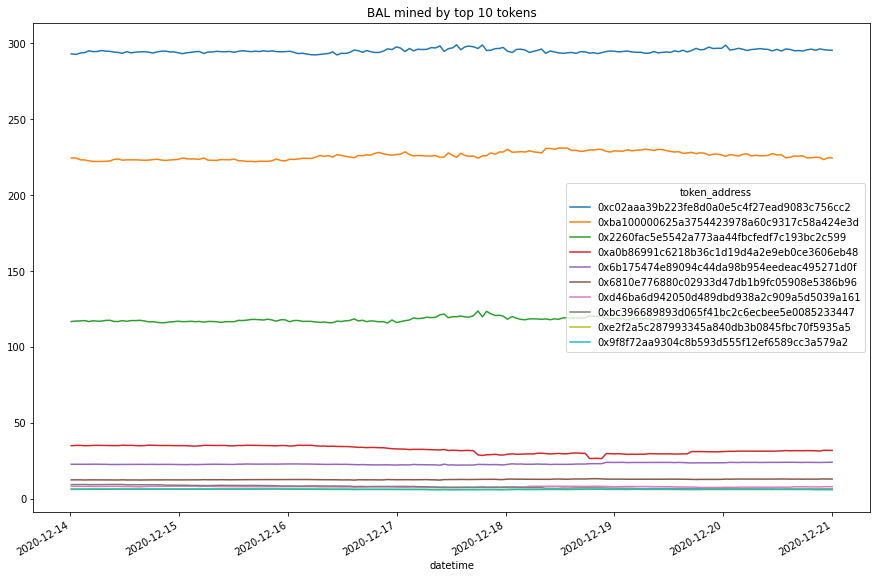

In [59]:
subpools['datetime'] = pd.to_datetime(subpools.timestamp, unit='s')
rewards_per_token = subpools.groupby(['token_address','datetime']).sum()['BAL_mined']
top_tokens = subpools['BAL_mined'].groupby(['token_address']).sum().sort_values(ascending=False).head(10).index
ax = pd.DataFrame(rewards_per_token).reset_index().\
    pivot(index='datetime', columns='token_address', values='BAL_mined')[top_tokens].\
    plot(figsize = (15,10),
         title = 'BAL mined by top 10 tokens')
print('Top 10 tokens:\n' + '\n'.join(top_tokens))

Top 10 pools:
0x1eff8af5d577060ba4ac8a29a13525bb0ee2a3d5
0x59a19d8c652fa0284f44113d0ff9aba70bd46fb4
0x9dde0b1d39d0d2c6589cde1bfed3542d2a3c5b11
0x8b6e6e7b5b3801fed2cafd4b22b8a16c2f2db21a
0xe867be952ee17d2d294f2de62b13b9f4af521e9a
0x7afe74ae3c19f070c109a38c286684256adc656c
0xe93e8aa4e88359dacf33c491cf5bd56eb6c110c1
0x8a649274e4d777ffc6851f13d23a86bbfa2f2fbf
0x221bf20c2ad9e5d7ec8a9d1991d8e2edcfcb9d6c
0x6b9887422e2a4ae11577f59ea9c01a6c998752e2


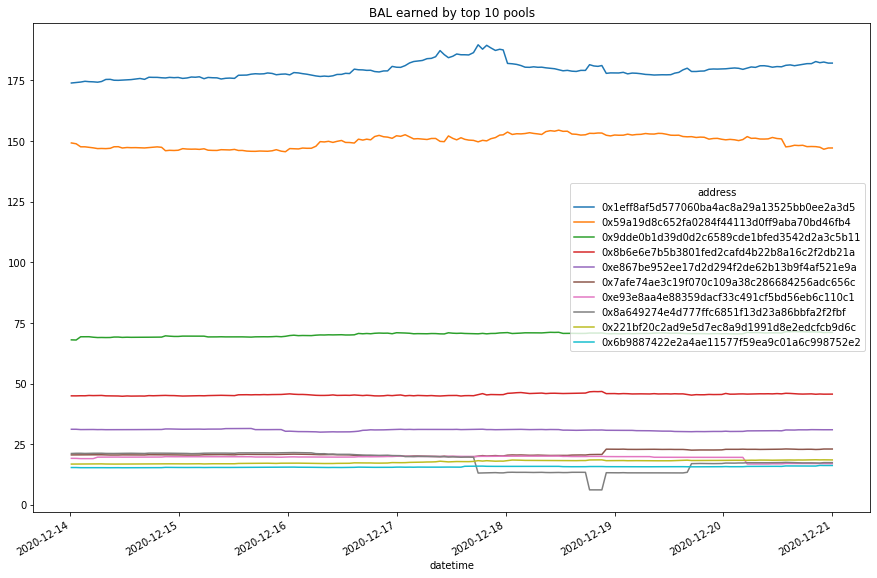

In [60]:
rewards_per_pool = subpools.groupby(['address','datetime']).sum()['BAL_mined']
top_pools = subpools['BAL_mined'].groupby(['address']).sum().sort_values(ascending=False).head(10).index
ax = pd.DataFrame(rewards_per_pool).reset_index().\
    pivot(index='datetime', columns='address', values='BAL_mined')[top_pools].\
    plot(figsize = (15,10),
         title = 'BAL earned by top 10 pools')
print('Top 10 pools:\n' + '\n'.join(top_pools))

Top 10 LPs:
0xAfC2F2D803479A2AF3A72022D54cc0901a0ec0d6
0x49a2DcC237a65Cc1F412ed47E0594602f6141936
0x39D787fdf7384597C7208644dBb6FDa1CcA4eBdf
0x66827bCD635f2bB1779d68c46aEB16541bCA6ba8
0xD85A7A3C5F08E3E709c233E133cE1335fBbF5518
0x821A96fbD4465D02726EDbAa936A0d6d1032dE46
0xa0f75491720835b36edC92D06DDc468D201e9b73
0x4f58985B75EeC8f14C536878A19EAdF4a1960D6c
0x97D4B02Ce33C399fFeC618Bfd2D5Bf7108e556ac
0xD856007b58A97d2f96B558a49CD3e7D3B1E96C0e


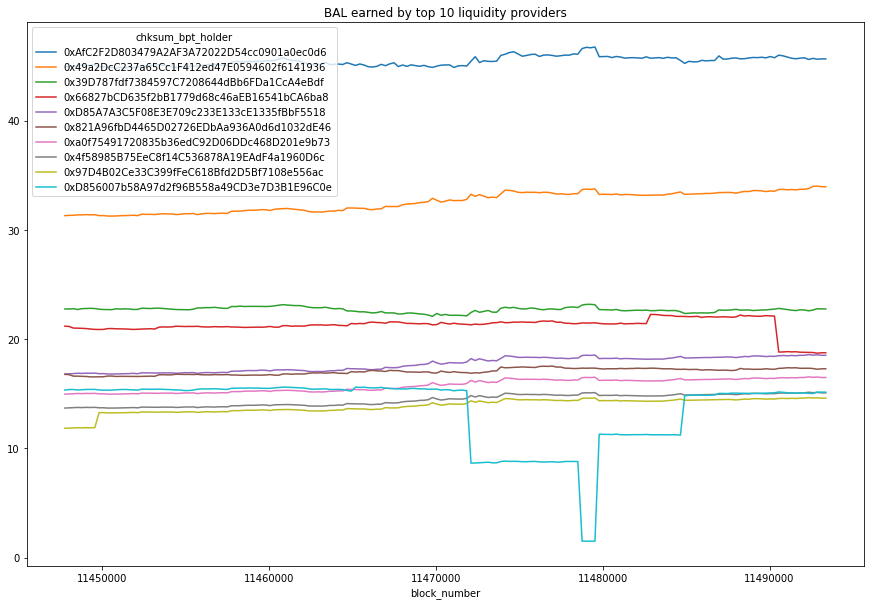

In [61]:
rewards_per_lp = bal_mined['bal_mined'].groupby(['chksum_bpt_holder','block_number']).sum()
top_lps = bal_mined['bal_mined'].groupby(['chksum_bpt_holder']).sum().sort_values(ascending=False).head(10).index
ax = pd.DataFrame(rewards_per_lp).reset_index().\
    pivot(index='block_number', columns='chksum_bpt_holder', values='bal_mined')[top_lps].\
    plot(figsize = (15,10),
         title = 'BAL earned by top 10 liquidity providers')
ax.ticklabel_format(axis='x', style='plain')
print('Top 10 LPs:\n' + '\n'.join(top_lps))

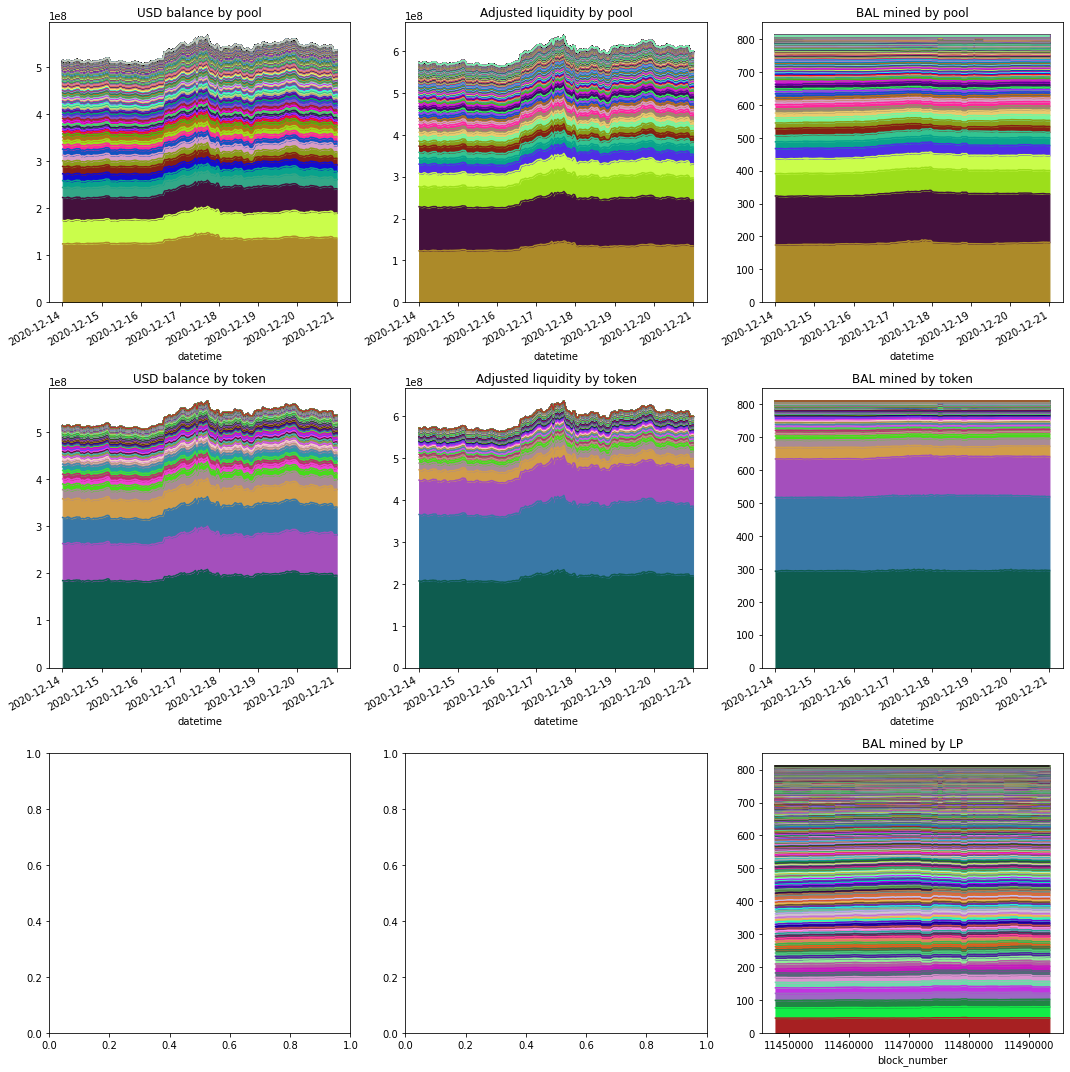

In [62]:
if not REALTIME_ESTIMATOR:
    from matplotlib.colors import ListedColormap
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))

    i = 0
    areaplot = subpools.groupby(['datetime','address']).sum().\
                reset_index().pivot(index='datetime', columns='address', values='usd_balance')
    # deterministically color code the regions of the plot for visual inspection between weeks
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='USD balance by pool', colormap=pal)

    i += 1
    areaplot = subpools.groupby(['datetime','address']).sum().\
                reset_index().pivot(index='datetime', columns='address', values='finalAdjustedLiquidity')
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='Adjusted liquidity by pool', colormap=pal)

    i += 1
    areaplot = subpools.groupby(['datetime','address']).sum().\
                reset_index().pivot(index='datetime', columns='address', values='BAL_mined')
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='BAL mined by pool', colormap=pal)

    i += 1
    areaplot = subpools.groupby(['datetime','token_address']).sum().\
                reset_index().pivot(index='datetime', columns='token_address', values='usd_balance')
    # deterministically color code the regions of the plot for visual inspection between weeks
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='USD balance by token', colormap=pal)

    i += 1
    areaplot = subpools.groupby(['datetime','token_address']).sum().\
                reset_index().pivot(index='datetime', columns='token_address', values='finalAdjustedLiquidity')
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='Adjusted liquidity by token', colormap=pal)

    i += 1
    areaplot = subpools.groupby(['datetime','token_address']).sum().\
                reset_index().pivot(index='datetime', columns='token_address', values='BAL_mined')
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='BAL mined by token', colormap=pal)

    i += 3
    areaplot = bal_mined.groupby(['block_number','chksum_bpt_holder']).sum().\
                reset_index().pivot(index='block_number', columns='chksum_bpt_holder', values='bal_mined')
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='BAL mined by LP', colormap=pal);
    axs.flat[i].ticklabel_format(axis='x', style='plain')

    plt.tight_layout()